# Fitting Models with Gradient Descent

Gradient descent and related methods are at the core of many optimization problems and machine learning algorithms.

## Motivation: Linear Regression

### Data and setup

Let's say we observe $n$ patients in a hospital, each of whom has measurements of their pre-treatment blood pressure, heart rate, etc. and also their corresponding blood pressure after taking a drug. For a new patient who walks in the door, given their current vital signs, can we predict their post-treatment blood pressure? 

The data for this kind of problem is most often formulated as vectors and matrices. We usually say that the $i$th patient's pre-treatment values are $x_i = [x_{i1}, x_{i2} \dots x_{ip}]$, so $x_{i1}$ is patient $i$'s pre-treatment blood pressure, $x_{i2}$ is their heart rate, etc. We also usually call the post-treatment blood pressure measurement for each patient $y_i$. So our goal is to predict $y_i$ from $x_i$ for a new patient who walks in the door.

Now we can stack up all the measurements for all the patients like this:

$$
X = \left[
\begin{array}{cccc}
x_{11} & x_{12} & \cdots & x_{1p} \\
x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & & \ddots & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{np} 
\end{array}
\right] = 
\left[
\begin{array}{cccc}
-3.2 & 28 & \cdots & 66 \\
8 & 22 & \cdots & 6.8 \\
\vdots & & \ddots & \vdots \\
0.54 & 10 & \cdots & 13 
\end{array}
\right]
\quad\quad
y = 
\left[
\begin{array}{c}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{array}
\right] 
= 
\left[
\begin{array}{c}
3.3 \\ 21.2 \\ \vdots \\ -9.97
\end{array}
\right] 
$$

We used pre-treatment vitals and post-treatment blood pressure as the predictors (or features) and outcome (or target) in our example, but this is the way we usually think of the data, no matter what the predictors and outcome are.

### Predicting

There are an infinite number of strategies we could use to try and guess what the relationship between $y_i$ and $x_i$ might be. We're going to presume that there is some relationship $y_i = f(x_i)$, and we want to figure out what $f$ is. You can think of the "real" $f$ as the function that the gods use to decide what a patient's blood pressure will be after treatment, given that the pre-treatment vitals were $x_i$. 

Since we don't know what $f$ is, we're going to try and guess. To make our job easier, we'll assume $f$ is a linear function of the form $x_i \beta + \alpha$. Our problem now reduces to guessing what the right $\alpha$ and $\beta$ are. 

<div class="alert alert-block alert-danger">
<b>WARNING:</b> Saying $f$ is linear (or of some other form) when it's really not is called <i>model misspecification</i>. We never know for sure the form that $f$ has, so in reality our models are almost always misspecified. If we only use the model for <i>prediction</i>, misspecification  doesn't invalidate the approach, it just means that the predictions won't be as accurate as they otherwise could be. On the other hand, if the model is used for <i>inference</i> (i.e. to estimate the effect of a variable on the outcome, with p-values, confidence intervals, etc.), then misspecification often invalidates the result. Be aware of this distinction.
</div>

Let's play god and simulate some data where a linear relationship actually does hold between $x_i$ and $y_i$ (and let's [use neat unicode symbols](https://github.com/jupyter/jupyter/issues/327) in our code!).:

In [335]:
import numpy as np

def to_array(β):
    if type(β) in (float, int, np.float64):
        return np.array([β]) # handle the case where user passes in a single number
    if type(β) is list:
        return np.array(β) # handle the case where user passes in a list
    return β

def simulate_linear(n, β=1, α=0, σ=1):
    β = to_array(β)
    p = len(β) # number of predictors we want
    X = np.random.rand(n,p)
    ϵ = np.random.normal(scale=σ, size=n) # random noise
    y = α + X@β + ϵ
    return X, y

In [4]:
X,y = simulate_linear(100, α=1, β=[1,-3,12])

Ok, now let's go back to being mere mortals. All we can see are these data $X$ and $y$. We don't even know for sure that the relationship is linear, much less what $\alpha$ and $\beta$ were. But we're going to take a leap of faith and pretend it's linear. The worst that happens is our predictions won't be very good.

Now all we need to do is find some values $\beta = [\beta_1, \dots \beta_p]^T$ and $\alpha$ so that $y_i \approx  x_i \beta + \alpha$ for all observed $y_i$ and $x_i$ in the data. That is, we need to find the values that make the model best "fit" the data. Once we have those best values, we can feed the vitals of a new patient $x_i$ into the formula $x_i \beta + \alpha$ to guess what their blood pressure $y_i$ will be. We often call the estimate $\hat y_i = x_i \beta + \alpha$. This whole process is called linear regression, which many of you are likely familiar with.

We can set up a little `LinearModel` class in python that encapsulates what we've said so far.

In [5]:
import numpy as np

class LinearModel():
    def __init__(self, α=None, β=None): 
        self.α = α # these are the "parameters" of the model
        self.β = to_array(β)
        
    def predict(self, X):
        return self.α + X @ self.β # returns ŷ

And we can test it out:

In [6]:
model = LinearModel(α=1, β=[1.1,-33,9]) # make a model with these coefficients
print(f'ŷ = {model.predict(X[0:5,:])}')
print(f'y = {y[0:5]}')

ŷ = [-13.16301189  -9.76725628 -10.93047664 -24.68828898   6.56525583]
y = [10.96199259  9.91667858  2.5389317  -0.79802221 13.06470167]


Obviously the predictions look very far off since we picked the values of $\alpha$ and $\beta$ at random

The question is: how do we find $\beta$ and $\alpha$ so that $y_i \approx  x_i \beta + \alpha$? 

### Defining a Loss

The first thing to do is quantitatively define what we mean by "$\approx$". We need a rule that tells us how good our approximation $\hat y_i$ is if the real blood pressure is $y_i$. We call that rule a *loss function* (sometimes also *cost* or *objective*). The loss tells us how much we "lose" by approximating $y_i$ with whatever value $\hat y_i$ is. Ultimately, that's a question that depends on what's important in the problem at hand, but often we default to using the squared-error loss function: $(y_i -  \hat y_i)^2$ The intuition is simple: subtract the estimate from the real value and square the result to make positive and negative deviations equal in penalty. To calculate the loss over the whole dataset (instead of just one individual $i$), we average the losses across each individual: $\frac{1}{n}\sum_i (y_i -  \hat y_i)^2$. This is called *mean-squared error* (MSE). In python:

In [7]:
def mse(y, ŷ):
    return np.mean(np.square(y-ŷ))

If we plug in $\hat y_i = x_i \beta + \alpha$, what we're looking for are values of $\alpha$ and $\beta$ that minimize the loss $\frac{1}{n} \sum_i(y_i - (x_i\beta + \alpha))^2$. So although we introduced the loss as a function of the truth $y_i$ and the estimate $\hat y_i$, we can look at it instead as a function of the parameters $\alpha$ and $\beta$: $L(\alpha, \beta) = \frac{1}{n} \sum_i(y_i - (x_i\beta + \alpha))^2$. The parameters are the only thing we can actually control to change the loss since $x_i$ and $y_i$ are just constants that are determined by the observed data.

So how do we find the $\alpha$ and $\beta$ that minimize the loss?

## Intuition: Turning the knobs

I find it useful to think about optimization problems in the following way: we have a complicated machine that makes an obnixous racket when it runs. However, there are a number of knobs we can turn that together might increase or decrease the horrible noise.

![](https://upload.wikimedia.org/wikipedia/commons/6/6a/TASCAM_M-520_knobs.jpg)

We don't know what position of the knobs produces the quietest running conditions, but by twisting them to a particular configuration, we can hear how noisy the machine is.

In our analogy, the knobs are the *parameters* of our model ($\alpha$ and $\beta$ in our example above), the machine is the loss function itself, and the volume of the noise is the value of the loss function at a particular setting of the parameters $L(\alpha, \beta)$. 

We can also visualize the loss as a surface. The horizontal axes correspond to the values of the parameters, while the vertical axis corresponds to the value of the loss at that set of parameter values.

![](https://algorithmia2.onpressidium.com/wp-content/uploads/2018/04/word-image-4.png)

The optimum point that we're looking for is the value of the parameters that minimizes the loss- so the lowest point on the surface. If there are more than two parameters ($p>2$), it is no longer possible to visualize this surface, but you can still think about it the same way. There is some "lowest point" on a surface in $p+1$-dimensional space, which is the configuration of the $p$ knobs that makes the machine run the quietest.

In general, we'll call the set of $p$ parameters $\theta = [\theta_1, \dots \theta_p]^T$ (these are our "knobs") and we'll call the loss function $L$. 

Don't confuse the surface of the loss function $L(\alpha, \beta)$ with the "surface" of the regression function $f_{\alpha, \beta}(x) = \alpha + x\beta$. When most people think about linear regression, the first thing that comes to mind is a line going through some points on a scatterplot (or a "plane" going through a "cloud" of points in higher dimensions)- that's $f_{\alpha, \beta}(x)$, for some particular values of $\alpha$ and $\beta$. But it's actually much more useful to think about the loss surface, which tells us how good each potential model is:

![](loss_didactic.png)

In this figure we see three different lines fit through the same set of points. Each of those is a different regression function $f_{\alpha, \beta}$, which is uniqely identified by the values of $\alpha$, $\beta$ used to draw the line. In higher dimensions, these would be "surfaces" that map a value of $x$ to a prediction $\hat y$. What the loss function does is assign a value $L$ to *each* of those surfaces (regression functions). Since each regression function is uniquely identified by its parameters, we can thus think of the loss as assigning a value $L$ to each set of parameters.

## Optimization by Random Search

One way to try and find a "good-enough" value of $\theta$ is to try lots of different values at random and pick whichever happens to produce the lowest loss. Let's try it out. 

First, for purposes of this demonstration, let's simplify the problem. We'll work in a setting where $X$ has only one column, meaning that $\beta$ is a scalar value and not a vector. That means our linear model has only two parameters, $\alpha$, and $\beta$.

In [25]:
X,y = simulate_linear(100, α=0, β=1, σ=0.25) # remember, in reality we don't know what these numbers actually are

In [26]:
αs = []
βs = []
losses = []

for guess in range(100):
    α = 200*np.random.rand(1)-100 # guess α is a number between -100 and 100
    β = 200*np.random.rand(1)-100 # guess β is a number between -100 and 100
    
    model = LinearModel(α, β)
    loss = mse(y, model.predict(X))
    
    losses.append(loss.item()) # .item() extracts the value out of the 1x1 array into a float
    αs.append(α.item())
    βs.append(β.item())

In [27]:
import pandas as pd
import altair as alt
random_guess_data = pd.DataFrame({'α':αs, 'β':βs, 'loss':losses})

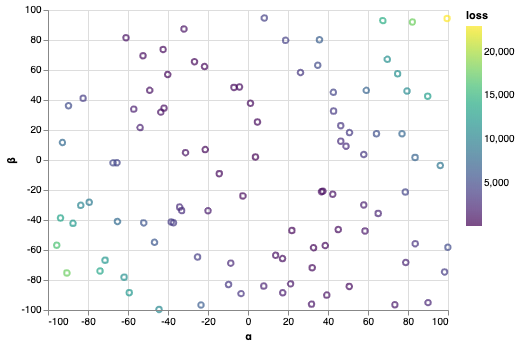

In [28]:
alt.Chart(random_guess_data).mark_point().encode(
    x = 'α',
    y = 'β',
    color = alt.Color('loss', scale=alt.Scale(scheme='viridis'))
)

Ok... let's pick the best parameters out of the ones we tried and see how good the resulting model is.

In [29]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [30]:
%%R -i random_guess_data -o best_guess # it's easier to do this part in R
library(tidyverse)
best_guess = filter(random_guess_data, loss == min(loss))

In [31]:
best_model = LinearModel(α=best_guess['α'].to_numpy(), 
                         β=best_guess['β'].to_numpy())
ŷ = best_model.predict(X)

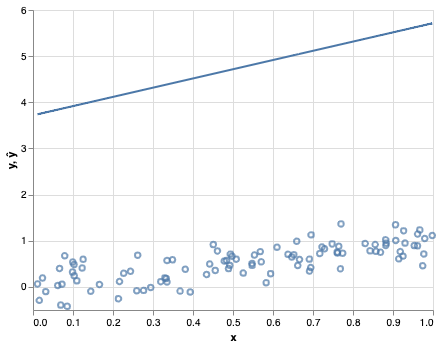

In [32]:
data_df = pd.DataFrame({'y':y, 'ŷ':ŷ, 'x':X[:,0]})
alt.Chart(data_df).mark_point().encode(x='x', y='y') + \
alt.Chart(data_df).mark_line().encode(x='x', y='ŷ')

Wow. Our best guess totally sucks.

Unfortunately there is no guarentee that we will hit any point that's close to the optimum. We could increase the number of guesses we make, but the more guesses, the longer it takes. The problem is exacerbated in higher-dimensional spaces because a fixed number of guesses covers less "volume" the more dimensions there are, so it's even harder to find points near the optimum. And even if a guess is very near the optimal value, the loss function may be very sensitive so that even a small distance away in terms of parameters translates to a big difference in terms of the loss. We also had to pre-specify a range of values to search over, but what if the optimal values aren't in that range? In problems with a single feature, we can easily plot the data to see what a range of plausible $\beta$s or $\alpha$s might be, but in higher dimensions this is impossible.

## Gradient Descent

Let's go back to our knobs. What if we try this strategy:
0. start with the knobs in a random configuration
1. fiddle each knob a tiny amount in both directions and record which direction decreases the output and by how much
2. turn each knob in the direction that decreased the output by an amount proportional to how much the output decreased during the fiddling
3. Repeat 1 and 2

Mathematically, that translates to this:
0. initialize $\theta$ to some random value $\theta_0$
1. calculate $\frac{\partial L}{\partial \theta}$
2. set $\theta$ to $\theta - \epsilon \frac{\partial L}{\partial \theta}$
3. repeat 1 and 2

Let's break down the math a little bit. 

First off, why does $\frac{\partial L}{\partial \theta}$ represent how much the loss changes when fiddling the knob a tiny amount? Well, because that's actually the definition of the derivative is: $\frac{\partial L}{\partial \theta} = \underset{\delta \rightarrow 0}{\lim} \frac{L(\theta + \delta) - L(\theta)}{\delta}$. That is precisely how much the loss increases ($L(\theta + \delta) - L(\theta)$) as we fiddle the $\theta$ knob an tiny amount $\delta$ to the right. 

If the derivative is positive, then the loss is increasing as $\theta$ is increasing, so we want to decrease $\theta$ in order to lower the loss. By the same logic, if the derivative is negative, then we want to increase theta. That's why there's a minus sign in the update that sets $\theta$ to $\theta - \epsilon \frac{\partial L}{\partial \theta}$.

As for the $\epsilon$, that's just a constant called the *learning rate* that mediates how big of a step we take. We'll experiment with this later.

The great thing about using the derivative instead of manually "fiddling the knobs" is that we don't even have to touch the knobs to know which direction we need to twist them in! If we have analytically derived the function $L_\theta'(\theta) = \frac{\partial L}{\partial \theta}$, all we need to do is plug in the current value of $\theta$ to get back how much we need to twist that "knob" and in what direction. 

### An example
Let's demonstrate by going back to our example. Our model is $\hat y_i = \alpha + x_i\beta$ and our loss is $L(y,\hat y) = \frac{1}{n}\sum_i (y_i - \hat y_i)^2$, so plugging in $\hat y$ we end up with this optimization problem:

$$\rightarrow \text{ Find } \alpha, \beta \text{ to minimize }\frac{1}{n} \sum_i (y_i - (\alpha + x_i\beta))^2 = L(\alpha, \beta)$$

The first step is to analytically calculate the derivatives with respect to each parameter. To get these, we can use the [chain rule and sum rule](https://en.wikipedia.org/wiki/Differentiation_rules).

$$\frac{\partial L}{\partial \alpha} = \frac{1}{n} \sum_i -2 (y_i - (\alpha + x_i\beta))$$

$$\frac{\partial L}{\partial \beta} = \frac{1}{n} \sum_i -2 (y_i - (\alpha + x_i\beta))x_i$$

<div class="alert alert-block alert-warning">
<b>STOP:</b> 
Review the rules of differentiation and try to calculate these derivatives for yourself if it's not obvious to you how we got here. <a href="https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/v/chain-rule-introduction">These videos give a helpful overview</a>.
</div>


Now we have something we can code up in python:

In [33]:
def dL_dα(α, β): # derivative of the MSE loss with respect to alpha, evaluated at (alpha, beta)
    β = to_array(β)
    return np.sum(-2*(y - (α + X@β)))/len(y)

def dL_dβ(α, β): # derivative of the MSE loss with respect to , evaluated at (alpha, beta)
    β = to_array(β)
    return np.sum(-2*(y - (α + X@β))*X[:,0])/len(y)

And now let's implement our gradient descent algorithm:

In [34]:
ϵ = 0.01 # learning rate
α, β = np.random.rand(2)
for i in range(1000):
    α = α - ϵ*dL_dα(α, β)
    β = β - ϵ*dL_dβ(α, β)

In [35]:
α, β

(0.05774348695997735, 0.9018532079612082)

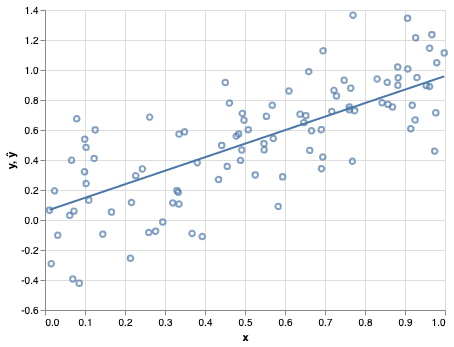

In [36]:
model = LinearModel(α, β)
ŷ = model.predict(X)
data_df = pd.DataFrame({'y':y, 'ŷ':ŷ, 'x':X[:,0]})
alt.Chart(data_df).mark_point().encode(x='x', y='y') + \
alt.Chart(data_df).mark_line().encode(x='x', y='ŷ')

Nailed it.

We can also improve it a little bit by repeating the loop until the loss is no longer quickly decreasing, instead of just looping 1000 times. Let's also record all of the parameter values and losses through the iterations.

In [37]:
α, β = np.random.rand(2)

In [38]:
ϵ = 0.01 # learning rate
tol = 0.00001 # tolerance
α, β = np.random.rand(2)
old_loss, loss = np.inf, mse(y, LinearModel(α,β).predict(X))
losses, βs, αs = [], [], []
while old_loss - loss > tol:
    α = α - ϵ*dL_dα(α, β)
    β = β - ϵ*dL_dβ(α, β)
    old_loss, loss = loss, mse(y, LinearModel(α,β).predict(X))
    βs.append(β.item())
    αs.append(α.item())
    losses.append(loss.item())
loss_params_trajectory = pd.DataFrame({'a':αs, 'b':βs, 'L':losses})

In [39]:
α, β

(0.11791543755564839, 0.7958687046287168)

Let's plot the trajectory of the parameters. To put it into context, we'll also brute-force calculate the value of the loss function for a grid of values around the trajectory so we can overlay the trajectory on the loss surface. Don't worry about this code- focus on the picture.

In [40]:
from itertools import product
αs = np.arange(np.min(αs)-np.ptp(αs)/4, np.max(αs)+np.ptp(αs)/4, np.ptp(αs)/50)
βs = np.arange(np.min(βs)-np.ptp(βs)/4, np.max(βs)+np.ptp(βs)/4, np.ptp(βs)/50)
params = list(product(αs, βs))
L = [None for i in range(len(params))]
for i, (α, β) in enumerate(params):
    m = LinearModel(α, β) 
    ŷ = m.predict(X)
    L[i] = mse(y,ŷ)
a,b = zip(*params)
loss_df = pd.DataFrame({'a':a, 'b':b, 'L':L})

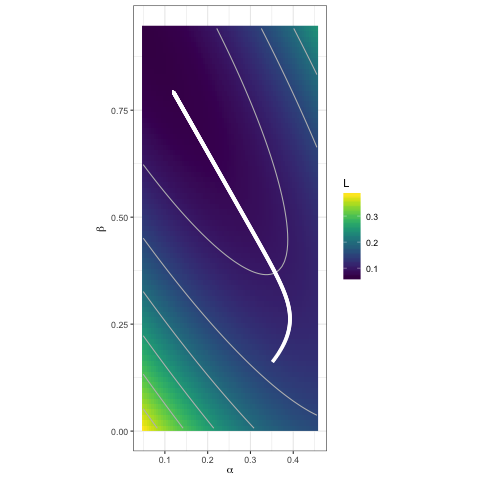

In [41]:
%%R -i loss_df,loss_params_trajectory
library(tidyverse)
library(viridis)

plot = loss_df %>%
ggplot(aes(x=a,y=b)) +
    geom_raster(aes(fill=L)) + 
    geom_contour(aes(z=L), color='grey') +
    scale_fill_viridis() +
    geom_segment(data=loss_params_trajectory, 
                 aes(x=a,y=b,xend=lead(a),yend=lead(b)),
                 color = 'white',
                 arrow = arrow(length=unit(0.10,"cm"), 
                             type = "closed")) + 
    labs(x = expression(alpha), y=expression(beta)) +
    theme_bw() + coord_fixed()
plot

Interesting! We see that the algorithm traverses the parameter space $(\alpha, \beta)$ by "going downhill" relative to the loss.

### Gradients: Vector-Valued Derivatives

Up to this point we've been talking about the derivatives of the loss with respect to each individual parameter. But now we're going to define taking the derivative with respect to a vector of parameters $\theta = [\theta_1, \theta_2, \dots \theta_p]^T$. How? It's pretty simple, we just stack the derivatives with respect to each parameter in the vector into a vector of its own:

$$
\frac{dL}{d\theta} = 
\left[
\begin{array}{c}
\frac{\partial L}{\partial \theta_1} \\
\frac{\partial L}{\partial \theta_2} \\
\vdots \\
\frac{\partial L}{\partial \theta_p}
\end{array}
\right]
= \nabla_\theta L
$$

And, instead of writing $\frac{dL}{d\theta}$, which might confuse someone into thinking $\theta$ is a single parameter, we usually write $\nabla_\theta L$. This is the *gradient* of $L$ with respect to the vector $\theta$. $\nabla_\theta L$ is a function that, when evaluated at a point $\theta^*$, returns a *vector*. The elements of that vector are the derivatives of the loss with respect to each individual parameter, evaluated at the value of that parameter. Check it out:

![](gradient.png)

The figure illustrates the contours of the loss function in grey (think of it as looking down into a "bowl"). The gradient evaluated at a single point returns a vector, which we draw as an arrow. The arrow points in the steepest direction "uphill" at that point. The steepest direction "downhill" is the direction corresponding to $-\nabla_\theta L$, the negative gradient. That's why we go in that direction in the gradient descent step, and it also explains why gradient descent works: at each step, we're moving the parameters in the direction that most decrease the loss.

Using the gradient, we can update all of the parameters in one equation: $\theta \leftarrow \theta - \epsilon \nabla_\theta L$. If you write out the components of each vector you will see that this is exactly the same as we had before when we were updating each parameter individually.

Let's rewrite our code to work generally in the multi-parameter case:

In [312]:
def grad_descent(L, grad_L, θ, ϵ=0.00001, tol=0.000001): # apparently ∇ can't be used in a variable name in python... so no ∇L
    old_loss, loss = np.inf, L(θ)
    while old_loss - loss > tol:
        θ -= ϵ*grad_L(θ)
        old_loss, loss = loss, L(θ)
    return θ

#### Example

Let's try it out with our linear regression problem using multiple predictors. Now we have $x_i = [x_{i1}, \dots x_{ip}]$ so $\beta = [\beta_1, \dots \beta_p]$. Our minimization problem is again

$$\underset{\alpha,\beta}{\text{argmin}}\frac{1}{n} \sum_i (y_i - (\alpha + x_i\beta))^2$$

You can read "$\underset{\theta}{\text{argmin}} L(\theta)$" as "the value of $\theta$ that minimizes $L(\theta)$", so this is just a little bit of shorthand for what we had written out in words before. This problem looks the same as what we had in the single-variable case, but actually now $x_i \beta$ is a dot product of two vectors instead of multiplication between two numbers. 

To calculate $\nabla_{\alpha, \beta} L(\alpha, \beta)$ we have to find the deriviatives with respect to each of the parameters $\alpha$, $\beta_1$, $\beta_2$, ... $\beta_p$. But even though now we have $p+1$ parameters, finding the derivatives is just as easy as in the 2-parameter case. If we expand out the dot product:

$$\frac{1}{n} \sum_i (y_i - (\alpha + x_i\beta))^2 = \frac{1}{n} \sum_i (y_i - (\alpha + x_{i1}\beta_1 + x_{i2}\beta_2 + \cdots x_{ip}\beta_p))^2$$

Now we can take our derivatives just as we had before. But we don't have to do all of the $\beta$s individually- if you do two of them you'll notice a pattern and see that the derivatives are:

$$\frac{\partial L}{\partial \alpha} = \frac{1}{n} \sum_i -2 (y_i - (\alpha + x_i\beta))$$

$$\frac{\partial L}{\partial \beta_j} = \frac{1}{n} \sum_i -2 (y_i - (\alpha + x_i\beta))x_{ij}$$

And, in fact, there's a quick way to write this out using matrix notation

$$
\left[
\begin{array}{c}
\frac{\partial L}{\partial \beta_1} \\
\frac{\partial L}{\partial \beta_2} \\
\vdots \\
\frac{\partial L}{\partial \beta_p}
\end{array}
\right]
= 
\nabla_\beta L(\alpha, \beta)
= 
-2X^T(y-(\alpha + X\beta))
$$

<div class="alert alert-block alert-warning">
<b>STOP:</b> 
Do the matrix multiplications yourself to verify that the equation for each partial derivative comes out the same. Feel free to review the <a href="https://www.khanacademy.org/math/precalculus/x9e81a4f98389efdf:matrices/x9e81a4f98389efdf:multiplying-matrices-by-matrices/a/multiplying-matrices">definition of matrix multiplication</a> if you're a little rusty.
</div>

Let's code it up!

In [313]:
X,y = simulate_linear(1000, α=0, β=[1,1,1], σ=0.25) # remember, in reality we don't know what these numbers actually are

In [314]:
# θ=[α, β1 ... βp]
def lin_reg_mse_loss(θ): # L(θ)
    m = LinearModel(α=θ[0], β=θ[1:])
    ŷ = m.predict(X)
    return mse(y,ŷ)

def grad_lin_reg_mse_loss(θ): # ∇L(θ) 
    Z = np.insert(X,0,1,axis=1) # adds a column of ones to the front of X. See ?np.insert
    return -2*Z.T @ (y-Z@θ) 

I used a little trick in the gradient function- if you pretend $\alpha$ is the coefficient for a dummy predictor that is always 1, the derivative for $\alpha$ takes the same form as the derivatives for $\beta_j$, so they can all be calculated in the same expression. That is, 

$$
\alpha + x_i \beta 
= 
\underbrace{[1, x_i]}_{z_i}
\underbrace{
\left[
\begin{array}{c}
\alpha \\ \beta
\end{array}
\right]
}_\theta
= z_i\theta
\quad \quad
\rightarrow
\quad \quad
\nabla_\beta L(\theta)
= 
-2Z^T(y-Z\theta)
$$

This isn't conceptually important- I could also have coded out the derivaties for $\alpha$ and $\beta$ separately and concatenated them together to get the gradient.

Finally, we can test out our generic gradient descent code:

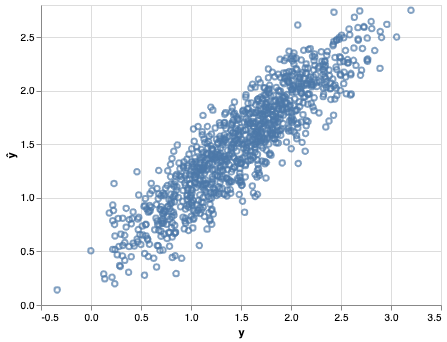

In [315]:
θ = grad_descent(lin_reg_mse_loss, grad_lin_reg_mse_loss, np.random.rand(X.shape[1]+1))
m = LinearModel(α=θ[0], β=θ[1:])
ŷ = m.predict(X)

print
preds = pd.DataFrame({'y':y,'ŷ':ŷ})
alt.Chart(preds).mark_point().encode(x='y',y='ŷ')

In [316]:
θ

array([0.07256887, 0.93959958, 0.94593482, 1.00041717])

Our predictions track very well with the observed values and the estimated parameters are close to what we put in the simulation, which means our algorithm works as intended.

#### Beyond Linear Regression

We've been working with our linear model and MSE loss, but there's no reason not to try gradient descent on other problems. For instance, what if we want to fit a model like $\hat y_i = \alpha\sin(x_i\beta)$? And what if we want to judge the predictions not with MSE, but with mean absolute error (MAE) $L(y,\hat y) = |y-\hat y|$? From the point of view of gradient descent, that's all just a different machine with different knobs, totally doable! For simplicity, we'll tackle the case where there is only a single feature (i.e. $\beta$ is a scalar, not a vector).

First, we compose the loss with the model to get the loss as a function of the parameters: $L(\alpha,\beta) = \frac{1}{n}\sum_i|y_i-\alpha\sin(x_i\beta)|$. Now we take derivatives:

$$
\nabla_{\alpha, \beta}L 
=
\left[
\begin{array}{c}
\frac{\partial L}{\partial \alpha} \\
\frac{\partial L}{\partial \beta}
\end{array}
\right]
= 
\left[
\begin{array}{c}
\sum_i-\text{sign}(y-\alpha\sin(x_i\beta)) \sin(x_i\beta) \\
\sum_i -\alpha \text{sign}(y-\alpha\sin(x_i\beta))(\cos(x_i\beta)) x_i
\end{array}
\right]
$$

And we code them up:

In [318]:
X = np.random.rand(100)
y = 5*np.sin(3*X) + np.random.rand(100)

In [319]:
# θ=[α, β1 ... βp]
def sin_reg_mae_loss(θ): # L(θ)
    ŷ = θ[0]*np.sin(X*θ[1])
    return np.mean(np.abs(y-ŷ))

def grad_sin_reg_mae_loss(θ): # ∇L(θ) 
    ŷ = θ[0]*np.sin(X*θ[1])
    dl_dα = np.mean(-np.sign(y-ŷ) * np.sin(X*θ[1]))
    dl_dβ = np.mean(-θ[0] * np.sign(y-ŷ) * np.cos(X*θ[1]) * X)
    return np.array([dl_dα, dl_dβ])

[5.48060352 2.97098603]


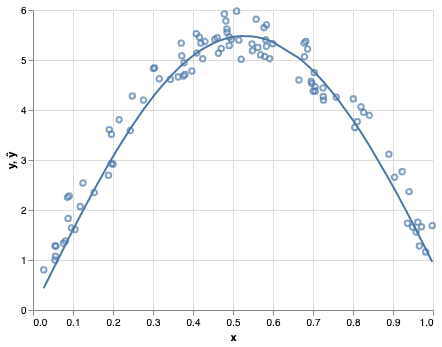

In [321]:
θ = grad_descent(sin_reg_mae_loss, grad_sin_reg_mae_loss, θ=np.array([0.1,0.1]), ϵ=0.1)
ŷ = θ[0]*np.sin(X*θ[1])

print(θ)
plot_df = pd.DataFrame({'y':y, 'x':X, 'ŷ':ŷ})
alt.Chart(plot_df).mark_point().encode(x='x',y='y') + \
alt.Chart(plot_df).mark_line().encode(x='x',y='ŷ')

You should now begin to grasp the power you have at your fingertips... 

![](https://steamuserimages-a.akamaihd.net/ugc/159157279551261206/BFA4AEC73F3B1165A1DA9EACDED6FBE9DE9213C1/)

<div class="alert alert-block alert-info">
<b>Exercise:</b> 

We've only considered regression problems (continuous $y$) thus far, but we can apply gradient descent to probabilistic classification (binary $y$) too. Instead of estimating $\hat y$, the expected value of $y$, we'll estimate $\hat p =P(y=1)$, the probability that the outcome occurs.

Using the "cross-entropy" loss $L(y,\hat p) = -y \log(\hat p) -(1-y)\log(1-\hat p)$, write code that fits the following model using gradient descent: $\hat p_i = \sigma(X\beta + \alpha)$, where $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. 
    
You can either use the `grad_descent` function we've written or use your own. It may be easier to start with the univariate case where $X$ is a single column (and $\beta$ is a scalar), then rewrite the code allowing for $X$ to have an aribrary number of columns.
    
What you've just done is called logistic regression!
</div>

## Issues with Gradient Descent

It may seem like we can solve practically any optimization problem with gradient descent at this point, but there are a few small wrinkles. Don't worry, though, we can mostly iron them out.

Let's start by looking at the sinusoidal regression problem we were just working on. We had set $\theta=[0.1,0.1]$ to start, but what happens if we set the initial $\theta$ to be something else?

[ 4.38829074 -6.89623011]


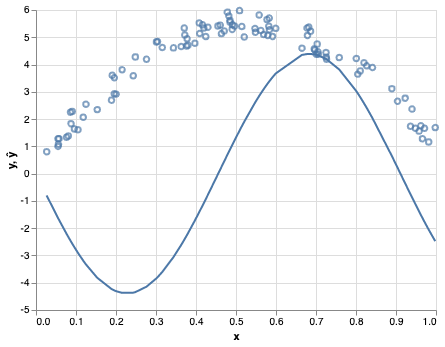

In [324]:
θ = grad_descent(sin_reg_mae_loss, grad_sin_reg_mae_loss, θ=np.array([10.0,-6.0]), ϵ=0.1)
ŷ = θ[0]*np.sin(X*θ[1])

print(θ)
plot_df = pd.DataFrame({'y':y, 'x':X, 'ŷ':ŷ})
alt.Chart(plot_df).mark_point().encode(x='x',y='y') + \
alt.Chart(plot_df).mark_line().encode(x='x',y='ŷ')

Wow. What the heck is going on?!

### Local Minima and Flats

I'm going to brute-force calculate the value of the loss function and gradient over a grid of parameters and plot it, so we can 
get an idea about what that loss surface looks like. Again, the code here is less important than the picture:

In [331]:
from itertools import product
αs = np.arange(0,10,0.5)
βs = np.arange(-10,10,0.5)
params = list(product(αs, βs))
L = [None for i in range(len(params))]
grads = [None for i in range(len(params))]
for i, (α, β) in enumerate(params):
    L[i] = sin_reg_mae_loss([α, β])
    grads[i] = 0.5*grad_sin_reg_mae_loss(np.array([α, β]))
a,b = zip(*params)
dL_da, dL_db = zip(*grads)
loss_df = pd.DataFrame({'a':a, 'b':b, 'dL_da':dL_da, 'dL_db':dL_db, 'L':L})

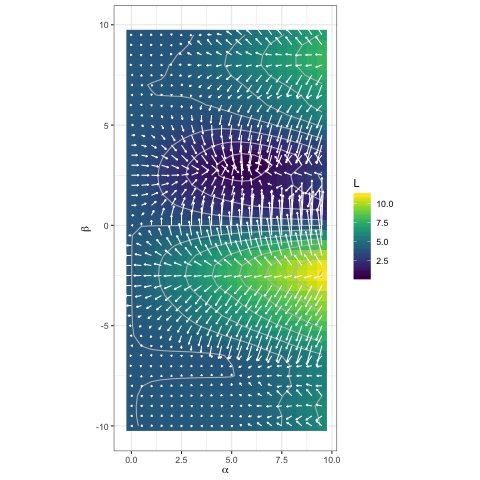

In [332]:
%%R -i loss_df,loss_params_trajectory
library(tidyverse)
library(viridis)

plot = loss_df %>%
ggplot(aes(x=a,y=b)) +
    geom_raster(aes(fill=L)) + 
    geom_contour(aes(z=L), color='grey') +
    scale_fill_viridis() +
    geom_segment(aes(x=a,y=b,xend=a-dL_da,yend=b-dL_db),
                 color = 'white',
                 arrow = arrow(length=unit(0.05,"cm"), 
                             type = "closed")) + 
    labs(x = expression(alpha), y=expression(beta)) +
    theme_bw() + coord_fixed()
plot

What's happening is that when we start at $[0.1, 0.1]$, gradient descent follows the arrows up and to the right into the pit that's centered around the $[5,3]$ minimum. But when we start at $[10,-6]$, we go left and get stuck in the trough roughly corresponding to $[4,-7]$. Either there is a small dip there that we're getting stuck in, or the surface is so near flat that the algorithm stops because the loss isn't changing enough with each step.

This is a very common problem with gradient descent methods for optimization. You are never guarenteed to find the global minimum of the loss. Greedily moving down in the steepest direction will cause the algorithm to find the bottom of a bowl, but it might not be the deepest bowl in the landscape. It's also easy to get stuck in wide plateaus or "saddles" since the loss can get very flat.

Before moving on to the tweaks we can make to fix this problem, I should note that there *are* optimization methods that don't rely on gradients and so are not succeptible to these problems. [Evolutionary algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm) like [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution) and [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) are good examples. But there's no free lunch: no gradients also often means a lot of "guessing" and slow convergence (many iterations to get to a minimum).

### Momentum 

One way to fix this problem without totally giving up on gradient descent is to introduce "momentum". Instead of taking a step proportional to the current gradient, the idea is to average the current gradient together with the steps taken in the previous few iterations. The effect is that we retain the "momentum" from previous steps. Compare these animations:

<table><tr><td><img src='http://www.eleven-lab.co.jp/blog/wp-content/uploads/2019/08/nomomentum1d.gif'></td><td><img src='http://www.eleven-lab.co.jp/blog/wp-content/uploads/2019/08/momentum1d.gif'></td></tr></table>

On the left, standard gradient descent slows down and stop as it approaches the local minimum around $\theta=4$. The reason is that the loss surface is flat there, so the gradient is $0$ and the parameters are unchanged. On the right, when the "ball" reaches the local minimum, the "momentum" from it's previous leftward "motion" carries it through the trough and into the more desirable global minimum. One downside is that convergence at the global minimum is a bit slower, since the parameters rock back and forth around the minimum due to the momentum.

Implementing momentum is not difficult- you just need to keep around the calculated values from previous iterations and apply the update something like this:

$$\theta \leftarrow \theta-\epsilon \nabla_\theta L -\frac{1}{2}\epsilon\nabla_\theta L ^{(-1)}- \frac{1}{4}\epsilon\nabla_\theta L ^{(-2)}$$

where $\nabla_\theta L ^{(-j)}$ is the value of gradient calculated at what the parameter was $j$ iterations ago. The exact number of terms you use and what numbers you scale them by are not terribly important, as long as the current gradient gets the most weight.

### Stochastic Gradient Descent

The value of the gradient at a particular point depends on the data we have. The data we have is really just a sample of the data we could have. Depending on the context, you could always run another experiment or measure more times than you did, which would generate more data. That data would also be helpful in building a predictive model. So, ideally, if we had infinite data, and using a model $\hat y_i = \hat f_\theta(x_i)$ we would want to minimize something like $\frac{1}{\infty}\sum_i^\infty L(y_i, \hat f_\theta(x_i))$. Another way of saying the same thing is that we want to minimize the *expected* loss, where the expectation is taken with respect to the full population (or distribution) of data that we could have measured: $E[L(y, \hat f_\theta(x))]$.

The key intuition here is that $E[L(y, \hat f_\theta(x))]$ is the *true* loss surface that we wish we could minimize, but all we've got to work with is $\frac{1}{n}\sum_i L(y_i, \hat f_\theta(x_i))$. So, in a sense, when we calculate the loss over our sample, it's really just a sample from a distribution of losses we could have gotten, had we had other data. In the same vein, the gradient we calculate is really just a sample from a distribution of gradients, which on average point in the direction of lowest expected loss.

The idea behind stochastic gradient is to calculate the gradient at each iteration using a random subsample of the available data instead of all of it. The full data are just one sample from the population, and we've been fine using the gradient calculated on that sample, so what's stopping us from calculating the gradient based on a sample of that sample? The effect is to introduce a little randomness to the direction we move in, which might get us "unstuck" from spots that might be minima or flats of $\frac{1}{n}\sum_i L(y_i, \hat f_\theta(x_i))$, but not of $E[L(y, \hat f_\theta(x))]$.

<div class="alert alert-block alert-info">
<b>Exercise:</b> 

This one is a little open-ended. See if you can implement stochastic gradient descent for the linear regression problem. You'll need to rewrite the loss and gradient functions to take (subsets of) $X$ and $y$ as inputs and the `grad_descent` function to create those random subsets at each iteration.
</div>

### Learning Rates and Line Searches

I've been conspicuously silent about the learning rate $\epsilon$ until now, but all good things must come to an end. If you go back to any of the examples and crank up $\epsilon$, you will notice that the algorithm stops producing sensible results at some point. What happens is that the loss increases from one iteration to the next, so the condition in the `while` loop is not satisfied and the algorithm stops. Why does this happen? Aren't we guarenteed to be going in a direction that shrinks the loss? Well, yes, the direction we're going in is gaurenteed to shrink the loss, but we may be taking too big of a step in that direction. Consider the following figure (they call the learning rate $\alpha$ instead of $\epsilon$):

![](https://miro.medium.com/max/800/0*00BrbBeDrFOjocpK.)

That should give you pretty much all the intuition you need about learning rates.

So what can be done about it? Do we have to re-run the model with decreasing learning rate until it converges? 

That's certainly one option, but most optimizers that are based on gradient descent employ some kind of *line search* to dynamically pick the step size at each iteration. It's called a line search because we know which direction to go in (the negative gradient), but we want to search along that line to find the step size that will decrease the loss and not badly overshoot the minimum. One way to do that is to start with a big learning rate and calculate the loss we would attain if we applied the gradient update- if it's bigger than the current loss, halve the learning rate and try again. That's called a [*backtracking line search*](https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture5.pdf), but there are other alternatives as well. 

## Don't Try This at Home (or do?)

To conclude, gradient descent is an extremely powerful method that in its many variations gets used under the hood of an enormous number of machine learning methods, ranging from the smallest linear regression to the mightiest neural network. Understanding how it works gives you a deeper insight for how machine learning models are fit- it all boils down to jiggling the knobs on a big complex machine until the noise you don't like goes away. 

Understanding how models are fit also gives you better insight for how to interpret them, which is to say, it's usually better not to. You never know "why" the particular configuration of the knobs made the noise go away. And it doesn't even matter if you assumed the correct model or if you assumed something totally ridiculous. The optimizer (e.g. gradient descent) looks for parameters that make the model "fit". It doesn't care whether or not that model reflects reality or not.

Unless you're researching a new kind of machine learning method or solving a different optimization problem, you will probably never have to use gradient descent algorithms directly. But if you do, the good news is that you don't need to re-implement gradient descent or any of its relatives if you want to use them- there are hundreds of high-quality "solvers" (e.g. [IPOPT](https://en.wikipedia.org/wiki/IPOPT)) available for different kinds of optimization problems. These can be a little tricky to figure out, but it's better than trying to implement and debug your own custom software. These solvers and [other methods you might hear about like Adam or RMSprop](https://ruder.io/optimizing-gradient-descent/) often have lots of bells and whistles. But now that you understand gradient descent, you will be well-positioned to understand the differences between those methods, whether or not those difference actually matter, and how to set reasonable values for any hyperparameters they might throw at you.